In [1]:
import pandas as pd
import numpy as np
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm, cross_validation, grid_search, feature_selection, metrics
from sklearn import feature_selection
from multiprocessing import Pool
import functools as fun
from gala import evaluate
from skimage import io

import brewer2mpl
import pylab
import matplotlib.pyplot as plt

%matplotlib inline  
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

# More fun with the BBBC021 dataset

Some additional classification, clustering and dimensionality reduction over the BBBC021 dataset for Microscopium. This follows on the last notebook, BBBC021-analysis.ipnb.

## Load the dataset

In [2]:
# load the screen features and wrangled annotation file
# how this was dervived is in the bbbc021-analysis2 notebook
bbbc021_merged = pd.read_csv("./bbbc021_merged.csv", index_col=0)
bbbc021_features = pd.read_csv("./BBBC021_feature.csv", index_col=0)

# drop DMSO -- as we showed before, it only has one annotation so it's not overly helpful
bbbc021_merged = bbbc021_merged[bbbc021_merged["compound"] != "DMSO"]

## More supervised learning experiments

In [3]:
# standardise the *whole* set of samples, including those that weren't annotated
std = StandardScaler().fit_transform(bbbc021_features.values)
bbbc021_features_std = pd.DataFrame(std, columns=bbbc021_features.columns, 
                                    index=bbbc021_features.index)

# get column indices for the three categories of features
object_cols = [col for col in bbbc021_features.columns if "pftas" not in col and "haralick" not in col]
haralick_cols = [col for col in bbbc021_features.columns if "haralick" in col]
pftas_cols = [col for col in bbbc021_features.columns if "pftas" in col]

### SVM

Previously we trained SVM's using data standardised against only samples that were annotated. Let's see how it goes. I'm only going to use the object features, I don't think the added complexity of new features is really worth the added complexity of more dimensions.

In [4]:
object_feats = bbbc021_features_std[object_cols]

svm_classifier = svm.SVC(kernel='linear', C=1)
scores = cross_validation.cross_val_score(svm_classifier, 
                                          object_feats.ix[bbbc021_merged.index].values, 
                                          bbbc021_merged["moa"].values,
                                          cv=5)
sum(scores / 5)

0.8210952380952381

Cool! Doing the standardisation with the full data-set doesn't change the performance! Let's try a kNN classifier over a few different values of k.

### kNN

Let's train a few kNN classifiers using a range of values for k. We'll use a ~~brute force~~ grid search method to find a decent k parameter. We should also use distance to weight the voting of the neighbours.

In [5]:
params = {"n_neighbors": [1, 3, 5, 7, 9]}
knn_classifier = KNeighborsClassifier(weights="distance")
knn_search = grid_search.GridSearchCV(knn_classifier, cv=5, param_grid=params)
knn_search.fit(object_feats.ix[bbbc021_merged.index].values, bbbc021_merged["moa"].values)
knn_search.grid_scores_

[mean: 0.75728, std: 0.04720, params: {'n_neighbors': 1},
 mean: 0.77670, std: 0.06894, params: {'n_neighbors': 3},
 mean: 0.75728, std: 0.06952, params: {'n_neighbors': 5},
 mean: 0.74757, std: 0.02040, params: {'n_neighbors': 7},
 mean: 0.74757, std: 0.02454, params: {'n_neighbors': 9}]

Whoah! That's actually pretty decent for a kNN classifier in high dimensions! I bet we could improve this using feature selection.. let's strip out low variance features.

In [6]:
var_thresh = feature_selection.VarianceThreshold(threshold=0.6)
object_feats_var = var_thresh.fit_transform(object_feats.ix[bbbc021_merged.index].values)
object_feats_var.shape

(103, 59)

In [7]:
knn_search.fit(object_feats_var, bbbc021_merged["moa"].values)
knn_search.grid_scores_

[mean: 0.79612, std: 0.07833, params: {'n_neighbors': 1},
 mean: 0.82524, std: 0.07706, params: {'n_neighbors': 3},
 mean: 0.82524, std: 0.04843, params: {'n_neighbors': 5},
 mean: 0.78641, std: 0.02668, params: {'n_neighbors': 7},
 mean: 0.76699, std: 0.01955, params: {'n_neighbors': 9}]

Yay, new best of ~0.82! When limiting the feature space to the features with the 59 greatest variances. We'd expect PCA to eliminate lots of the low-variance features. Let's try it now.

### PCA

In [8]:
# create three projections of the data, one is the first 50 principal components, 
# then the first two principal components, then TSNE for later on

# again, we use the full data-set for the embedding then use the annotated samples
# only to estimate the accuracy of knn
pca_50 = PCA(n_components=50).fit_transform(object_feats.values)
pca_2 = PCA(n_components=2).fit_transform(object_feats.values)

# get these back into data-frame form so we can index them
pca_50 = pd.DataFrame(pca_50, index=object_feats.index)
pca_2 = pd.DataFrame(pca_2, index=object_feats.index)

In [9]:
# Now let's try the projections with kNN!

knn_search.fit(pca_50.ix[bbbc021_merged.index], bbbc021_merged["moa"].values)
knn_search.grid_scores_

[mean: 0.76699, std: 0.04205, params: {'n_neighbors': 1},
 mean: 0.78641, std: 0.07237, params: {'n_neighbors': 3},
 mean: 0.75728, std: 0.04944, params: {'n_neighbors': 5},
 mean: 0.73786, std: 0.02293, params: {'n_neighbors': 7},
 mean: 0.74757, std: 0.04607, params: {'n_neighbors': 9}]

In [10]:
knn_search.fit(pca_2.ix[bbbc021_merged.index], bbbc021_merged["moa"].values)
knn_search.grid_scores_

[mean: 0.43689, std: 0.03689, params: {'n_neighbors': 1},
 mean: 0.41748, std: 0.06972, params: {'n_neighbors': 3},
 mean: 0.45631, std: 0.10363, params: {'n_neighbors': 5},
 mean: 0.46602, std: 0.10110, params: {'n_neighbors': 7},
 mean: 0.45631, std: 0.09204, params: {'n_neighbors': 9}]

Not great, but we don't expect much better from PCA.

### Optimising tSNE

We love tSNE, but the problem is that the performance is really, really sensitive to the choice of learning rate. Parameters, bah. What are they good for? In practice you can get a good result by tweaking this manually, but I'm lazy and want to automate this.

We can use a heuristic for the best TSNE embedding though.. find the learning rate that minimises the distance between replicates, and maximises the distance between samples that aren't replicates! Yay, semi-labelled data! I'll use the minimum of the ratio of these two quantites as a heuristic for the best learning rate.

We'll need to load up some metadata to do this. We also need to restrict the samples we look at to those that actually have treatment annotations -- we're still using the full set of sample, but doing the optimisation based on the annotated samples.

In [11]:
bbbc021_metadata = pd.read_csv("./BBBC021_parsed_metadata.csv", index_col=0)
bbbc021_metadata = bbbc021_metadata.drop_duplicates()
treatments = bbbc021_metadata["Image_Metadata_Compound"].unique()

In [12]:
# rather than find the full n_sample * n_sample distance matrix we'll interate over the 
# treatments and find the distances

# i'm sure there's some prettier way to do this but my terrible
# academic code hack approach will get the job done for the moment :P

def mean_pairwise_distances_within(tsne_df):
    dist_sum = 0
    dist_count = 0
    for treatment in treatments:
        treatment_idx = bbbc021_metadata[bbbc021_metadata["Image_Metadata_Compound"]==treatment].index
        pairwise_dist = distance.pdist(tsne_df.ix[treatment_idx][[0, 1]])

        dist_sum += sum(pairwise_dist)
        dist_count += len(pairwise_dist)
    
    return dist_sum / dist_count

# get a sample of 2000 pairwise distances between random samples
def mean_pairwise_distances_outside(tsne_df):
    dist_sum = 0
    dist_count = 0
    
    tsne_df_annot = tsne_df.ix[bbbc021_metadata.index]
    
    while dist_count < 2000:
        i, j = np.random.randint(tsne_df_annot.shape[0]), np.random.randint(tsne_df_annot.shape[0])
        
        if tsne_df.ix[i]["treatment"] != tsne_df.ix[j]["treatment"]:
            dist_sum += distance.pdist(tsne_df_annot.ix[[i, j]][[0, 1]].values)[0]
            dist_count += 1
            
    return dist_sum / dist_count

# return a tuple of (n_components, learning_rate, tsne_df, dist_within, dist_between)
def benchmark_tsne(n, rate_seed):# if this works in the first shot i may finally actually understand pandas
    
    tsne_ = TSNE(n_components=n, learning_rate=rate_seed[0], 
                 random_state=rate_seed[1]).fit_transform(pca_50)
    tsne_df = pd.DataFrame(tsne_, index=object_feats.index)
    
    tsne_df_annot = tsne_df.ix[bbbc021_metadata.index]
    tsne_df_annot["treatment"] = bbbc021_metadata["Image_Metadata_Compound"]
    
    dist_within = mean_pairwise_distances_within(tsne_df_annot)
    dist_between = mean_pairwise_distances_outside(tsne_df_annot)
    
    return (n, rate_seed, tsne_df, dist_within, dist_between)

In [13]:
# TSNE doesn't use multple cores, but we can do the grid search over the parameters in parallel!
pool = Pool() # use all cores available

# search over the range of TSNE learning rates
# we choose [100, 1000] as these are the recommended ranges
# we choose 9 for no reason other than I can plot the results in a pretty 3x3 plot
learning_rates = np.linspace(100, 1000, 9)

# use a different seed for each run of TSNE
tsne_seeds = [23, 489, 1354, 478, 9632, 951, 357, 125, 222]

rate_seeds = zip(learning_rates, tsne_seeds)

# two partial functions, let's test the difference between 2d and 3d tsne embeddings!
# will take a little while..
_tsne2 = fun.partial(benchmark_tsne, 2)
benchmark_tsne_2 = pool.map(_tsne2, rate_seeds)

# _tsne3 = fun.partial(benchmark_tsne, 3)
# benchmark_tsne_3 = pool.map(_tsne3, learning_rates)

Okay, everything is in place! We've got 9 tSNE embeddings using different learning rates. Let's now plot these embeddings limiting the samples to those with mechanism of action annotations and colour them. We'll create 9 plots, and include the performance of a 5-NN classifier corresponding to the embedding along with the ratio of the within/between distances.

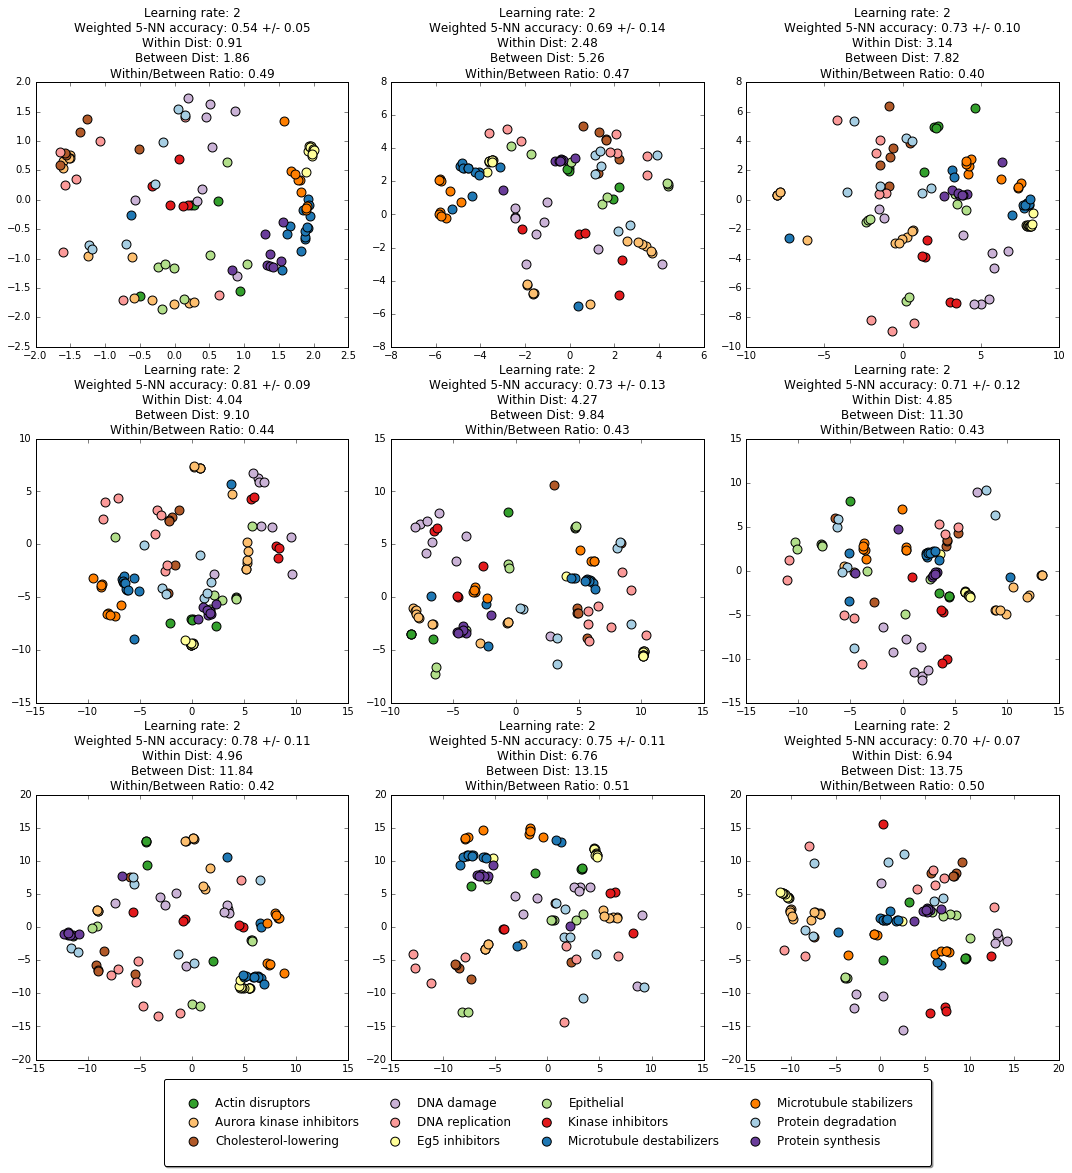

In [14]:
# now let's create some plots!

# setup the categorical color scale for the mechanisms of action
labels = list(set(bbbc021_merged["moa"]))
bmap = brewer2mpl.get_map("Paired", "Qualitative", 12)
color_scale = dict(zip(labels, bmap.mpl_colors))

plt.figure(figsize=(3*5, 3*5))

knn5_classifier = KNeighborsClassifier(n_neighbors=5, weights="distance")

for i in range(9):    
    # restrict data-points to those with mechanism of action annotation,
    # and add the moa to the data-frame so we can colour the plot
    # points
    _df = benchmark_tsne_2[i][2].ix[bbbc021_merged.index]
    _df.columns = ["x", "y"]
    _df["label"] = bbbc021_merged["moa"]
    groups = _df.groupby("label")
    
    # get ratio of mean within and mean between distances
    within = benchmark_tsne_2[i][3]
    between =  benchmark_tsne_2[i][4]
    ratio = within / between
    
    # 3 k-nn accuracy for this embedding
    # use the whole dataset
    scores = cross_validation.cross_val_score(knn5_classifier, _df[["x", "y"]], 
                                              _df["label"], cv=5)
    
    # lolwhat mpl
    plt.subplot(330 + i + 1)

    for name, group in groups:
        plt.scatter(group.x, group.y, s=80, label=name, c=color_scale[name])
        title_format = "Learning rate: {0}\n"
        title_format += "Weighted 5-NN accuracy: {1:.2f} +/- {2:.2f}\n"
        title_format += "Within Dist: {3:.2f}\n"
        title_format += "Between Dist: {4:.2f}\n"
        title_format += "Within/Between Ratio: {5:.2f}"
        
        plt.title(title_format.format(benchmark_tsne_2[i][0], 
                                      np.mean(scores), np.std(scores),
                                      within, between, ratio))
        
    # add legend below penultimate plot (is there no better way to do this?!)
    if i == 7:
        plt.legend(scatterpoints=1, loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=4, borderpad=1.5)

plt.tight_layout()
plt.show()

### Clustering metrics and tSNE

Now as we did before, we'll do some clustering in the tSNE space and see how it stacks up versus the class labels.

In [15]:
ag_clustering = AgglomerativeClustering(n_clusters=12, affinity="euclidean", linkage="complete")
ag_predict = ag_clustering.fit_predict(X=benchmark_tsne_2[3][2].ix[bbbc021_merged.index])

metrics.adjusted_rand_score(bbbc021_merged["moa"].values, ag_predict)

0.46598946664633506

In [16]:
str_to_int = LabelEncoder().fit(bbbc021_merged["moa"].values)
evaluate.vi(str_to_int.fit_transform(bbbc021_merged["moa"].values), 
            str_to_int.fit_transform(ag_predict))

1.9164834753419924

### Classifying new samples with tSNE

Now, let's randomly take 10 samples and see what class the k-NN classifier assigns them to! We'll use the full set of data to train the classifier, and use a learning rate of 

In [17]:
# train the classifier with the full data-set
_df_train = benchmark_tsne_2[3][2].ix[bbbc021_merged.index]
_df_train.columns = ["x", "y"]
_df_train["label"] = bbbc021_merged["moa"]
_knn5 = knn5_classifier.fit(_df_train[["x", "y"]], _df_train["label"])

In [18]:
np.random.seed(seed=33)

# get samples with an annotation, but no noted mechanism of action
unannot_index = np.setdiff1d(bbbc021_metadata.index, bbbc021_merged.index)
unannot_sample = np.random.choice(unannot_index, 10)
_df_test = benchmark_tsne_2[3][2].ix[unannot_sample]
_df_test.columns = ["x", "y"]

pred = _knn5.predict(_df_test[["x", "y"]])

predicted = pd.DataFrame({"Treatment": bbbc021_metadata.ix[unannot_sample]["Image_Metadata_Compound"],
                          "Predicted MoA": pred})
predicted

Predicted MoA         Treatment
BBBC021-22123-E06  Microtubule destabilizers        nocodazole
BBBC021-29301-F06   Aurora kinase inhibitors     methoxylamine
BBBC021-39282-C04            DNA replication  deoxynojirimycin
BBBC021-34661-F10          Kinase inhibitors         PD-169316
BBBC021-38341-E09                 Epithelial              PP-2
BBBC021-25681-D07                 DNA damage          PD-98059
BBBC021-22361-E06   Aurora kinase inhibitors        colchicine
BBBC021-25681-C09          Protein synthesis           emetine
BBBC021-24121-F06            DNA replication         genistein
BBBC021-22361-F10   Aurora kinase inhibitors         monastrol

Alright, so how does the predicted MoA correspond to the prediction? We'll manually try and match the compound with the predicted mechanism of action keeping in mind some compounds may be experimental, or have limited literature available so this may not be perfect.

* nocodazole - This is a microtubule destabilizer as predicted [ref](https://pubchem.ncbi.nlm.nih.gov/compound/nocodazole#section=Top)
* methoxylamine - This compound is involved in DNA damage [ref](https://www.ncbi.nlm.nih.gov/pubmed/11585361)
* deoxynojirimycin - This is an anti-viral that inhibits DNA polymerase, so it affets DNA replication as predicted [ref](https://pubchem.ncbi.nlm.nih.gov/compound/1-deoxynojirimycin#section=Pharmacology-and-Biochemistry)
* PD-169316 - This is a protein kinase inhibitor as predicted [ref](https://www.caymanchem.com/product/10006727)
* PD-98059 - This is a protein kinase inhibitor per pubchem [ref](https://pubchem.ncbi.nlm.nih.gov/compound/pd_98059#section=Pharmacology-and-Biochemistry) but can't find anything relating to its role in DNA damage
* PP2 - This is a kinase inhibitor according to pubhem [ref](http://www.signalchem.com/products/biochemical-compounds/kinase-inhibitors/details.php?name=PP2&refnum=6924)
* colchicine - This is a microtubule destabilizer, can't find evidence that it inhibits aurora kinases [ref](https://pubchem.ncbi.nlm.nih.gov/compound/colchicine#section=Top)
* emetine - This is a protein synthesis	inhibitor as predicted [ref](https://pubchem.ncbi.nlm.nih.gov/compound/emetine#section=Top)
* genistein - This paper suggests it's involved in protecting particular cells from DNA damage? I'll put this down as a maybe [ref](https://www.ncbi.nlm.nih.gov/pubmed/24614013)'
* monastrol - I can't say [ref](https://pubchem.ncbi.nlm.nih.gov/compound/794323)

So all up, 5 samples matched their predicted mechanism of action, 2 samples were treated with compounds that have limited literature and 3 seemed to be misclassified. Let's look at the selected images against an example image from their predicted class.

In [19]:
predicted["sample_image"] = [
    "./classification/BBBC021-22123-E06.jpeg",
    "./classification/BBBC021-29301-F06.jpeg",
    "./classification/BBBC021-39282-C04.jpeg",
    "./classification/BBBC021-34661-F10.jpeg",
    "./classification/BBBC021-38341-E09.jpeg",
    "./classification/BBBC021-25681-D07.jpeg",
    "./classification/BBBC021-22361-E06.jpeg",
    "./classification/BBBC021-25681-C09.jpeg",
    "./classification/BBBC021-24121-F06.jpeg",
    "./classification/BBBC021-22361-F10.jpeg"
]

predicted["predicted_image"] = [
    "./classification/BBBC021-22123-D03-microtubule-stabilizer.jpeg",
    "./classification/BBBC021-22123-G05-aurora-kinase-inhibitor.jpeg",
    "./classification/BBBC021-39282-B04-dna-replication.jpeg",
    "./classification/BBBC021-34661-G05-kinase-inhibitor.jpeg",
    "./classification/BBBC021-28901-B04-epithelial.jpeg",
    "./classification/BBBC021-27801-G05-dna-damage.jpeg",
    "./classification/BBBC021-22123-G05-aurora-kinase-inhibitor.jpeg",
    "./classification/BBBC021-27801-B05-protein-synthesis.jpeg",
    "./classification/BBBC021-39282-B04-dna-replication.jpeg",
    "./classification/BBBC021-22123-G05-aurora-kinase-inhibitor.jpeg"
]

predicted["actual_moa"] = [
    "Microtubule destabilizers",
    "DNA Damage",
    "DNA replication",
    "Kinase inhibitors",
    "Kinase inhibitors",
    "Kinase inhibitors",
    "Microtubule destabilizers",
    "Protein synthesis",
    "DNA damage",
    "Unknown"
]

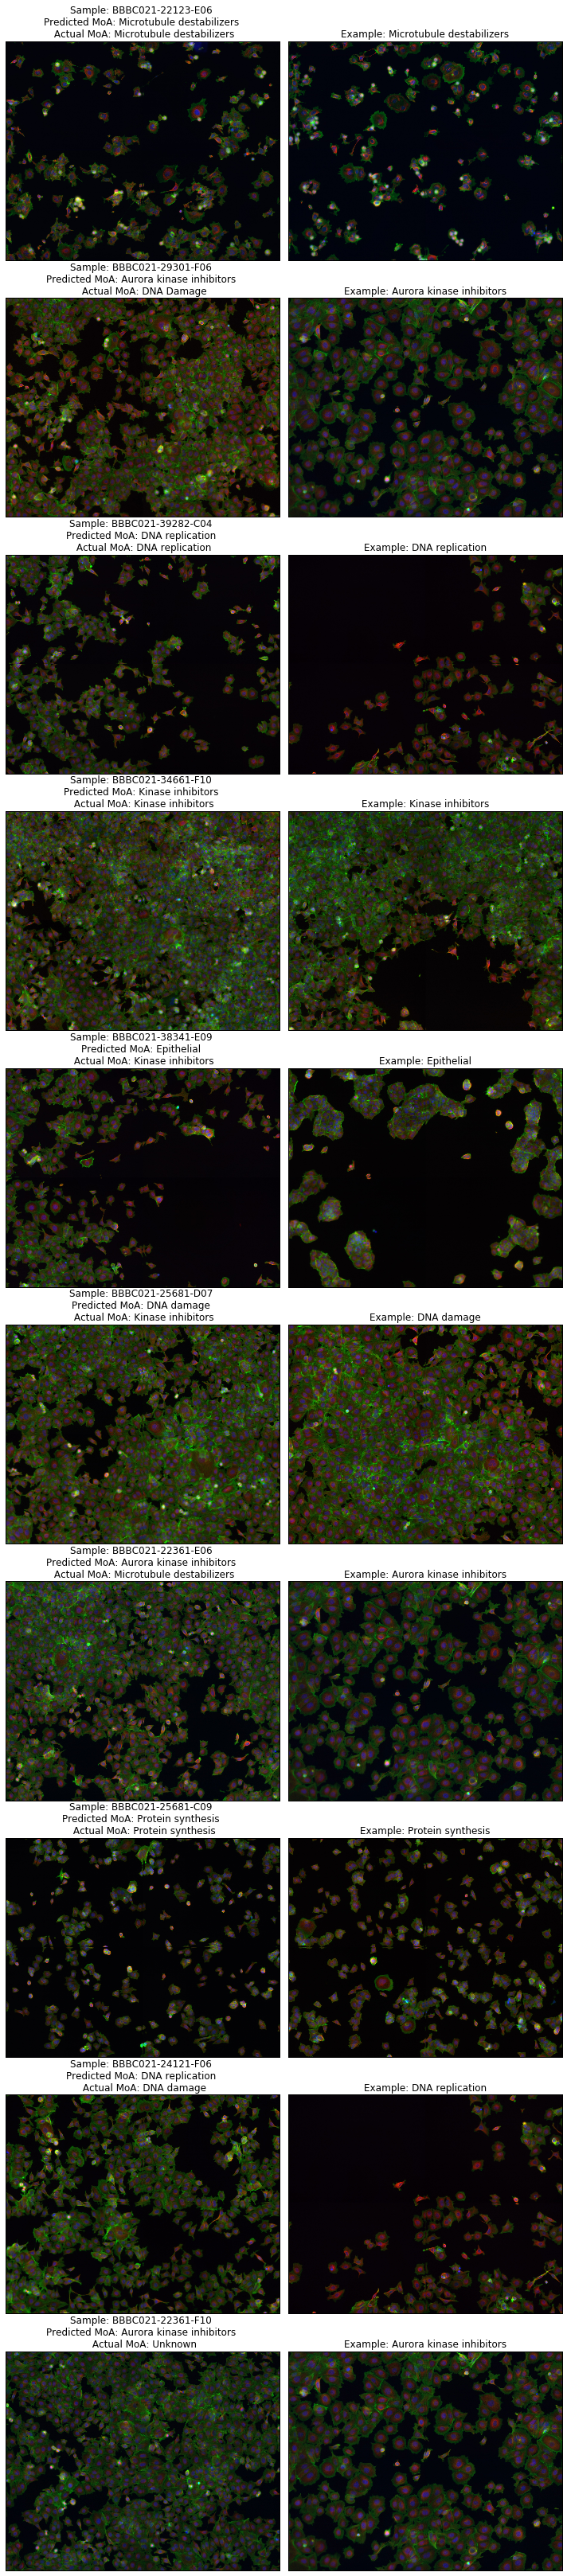

In [20]:
plt.figure(figsize=(2*5, 9*5))

# why pandas whyyyy
for i, row in enumerate(predicted.iterrows()):
    ax1 = plt.subplot(10, 2, 2*i + 1)
    ax1.imshow(io.imread(row[1][2]))
    ax1.axes.get_xaxis().set_visible(False)
    ax1.axes.get_yaxis().set_visible(False)    
    ax1text = "Sample: {0} \nPredicted MoA: {1} \n Actual MoA: {2}".format(row[0],
                                                                        row[1][0],
                                                                        row[1][4])
    ax1.axes.set_title(ax1text)

    
    ax2 = plt.subplot(10, 2, 2*i + 2)
    ax2.imshow(io.imread(row[1][3]))
    ax2.axes.get_xaxis().set_visible(False)
    ax2.axes.get_yaxis().set_visible(False)
    ax2text = "Example: {0}".format(row[1][0])
    ax2.axes.set_title(ax2text)

plt.tight_layout()
plt.show()

## Conclusions

* Nearest neighbour classification rates were around ~%80 using the 59 features with the greatest variance.
* tSNE reliably creates groupings with classification accuracy of ~%75 with a nearest neighbour classifier. We get as high as ~%80 with some embeddings. Very cool!
* Adjusting the learning rate has an effect on the accuracy of the embedding, so it's worth trying to tweak this. We can do this in a quasi-supervised manner using distances between replicates/non-replicates.
* Using the heuristic of minimising the ratio of within-replicate and between-replicate distance is a reasonable estimate of the optimal tSNE learning rate. I'm not sure how well this perform if tSNE fails for some reason (e.g. it gets stuck in a local minimum and the data stays in a big blob. This can happen with small data-sets and high learning rates.)
* Misclassified images are due to phenotypic similarity between classes with different MoAs. There may also be be some overlap between MoAs -- e.g. compunds resulting in DNA damage may affect pathways in DNA replication.